# Impoerting tools and libararies

In [1]:
import os, glob
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import multiprocessing
from copy import deepcopy
from sklearn.metrics import precision_recall_curve, auc
from tensorflow.keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
from tensorflow.random import set_seed 
set_seed(10)
%matplotlib inline
train_on_gpu = True
from PIL import Image
import albumentations as albu
import matplotlib.pyplot as plt
import seaborn as sns

# Loading dataset

In [2]:
path = 'C:\\Users\\abasd\\OneDrive - Coventry University\\Masters\\MSc thesis\\Code\\cloud_dataset'
train_data = pd.read_csv(f'{path}/train.csv')
train_df = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')
os.listdir(path)

['sample_submission.csv', 'test_images', 'train.csv', 'train_images']

In [3]:
test_imgs_dir = 'C:\\Users\\abasd\\OneDrive - Coventry University\\Masters\\MSc thesis\\Code\\cloud_dataset\\test_images'
train_imgs_dir = 'C:\\Users\\abasd\\OneDrive - Coventry University\\Masters\\MSc thesis\\Code\\cloud_dataset\\train_images'
num_cores = multiprocessing.cpu_count()

# Data preprocessing

In [4]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()

count_of_class = [] 
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
    count_of_class.append(train_df[train_df[class_name] == 1][class_name].value_counts()[1])

count_of_class = pd.DataFrame({
    'Class': classes,
    'Count': count_of_class
}) 
      
train_df['Exclusive'] = train_df['Class'].map(lambda x: 1 if len(x) == 1 else 0)
train_df['Count_Class_Overlap'] = train_df['Fish'] + train_df['Flower'] + train_df['Sugar'] + train_df['Gravel']
train_df['Class_str'] = train_df['Class'].astype(str)

train_df.head(10)

,Image,Class,Fish,Flower,Sugar,Gravel,Exclusive,Count_Class_Overlap,Class_str
0,0011165.jpg,"{Flower, Fish}",1,1,0,0,0,2,"{'Flower', 'Fish'}"
1,002be4f.jpg,"{Sugar, Flower, Fish}",1,1,1,0,0,3,"{'Sugar', 'Flower', 'Fish'}"
2,0031ae9.jpg,"{Sugar, Flower, Fish}",1,1,1,0,0,3,"{'Sugar', 'Flower', 'Fish'}"
3,0035239.jpg,"{Flower, Gravel}",0,1,0,1,0,2,"{'Flower', 'Gravel'}"
4,003994e.jpg,"{Sugar, Fish, Gravel}",1,0,1,1,0,3,"{'Sugar', 'Fish', 'Gravel'}"
5,00498ec.jpg,{Gravel},0,0,0,1,1,1,{'Gravel'}
6,006bf7c.jpg,"{Sugar, Fish}",1,0,1,0,0,2,"{'Sugar', 'Fish'}"
7,006c5a6.jpg,"{Sugar, Fish}",1,0,1,0,0,2,"{'Sugar', 'Fish'}"
8,008233e.jpg,{Sugar},0,0,1,0,1,1,{'Sugar'}
9,008a5ff.jpg,"{Sugar, Fish}",1,0,1,0,0,2,"{'Sugar', 'Fish'}"


***Lets check number of images with mutilpe classification and images with single classification and count number of occurences for each class**

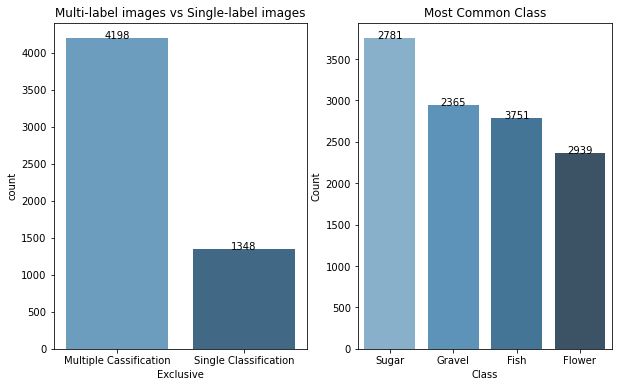

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)

'''
the code below is to check and plot
the number  of images with multi-label
classification and number of images with
single classification
'''
ax1.plot()
fig.set_size_inches(10,6)
sns.countplot(x='Exclusive', data=train_df, palette="Blues_d", ax=ax1)
ax1.set_title('Multi-label images vs Single-label images')
ax1.set_xticklabels(['Multiple Cassification','Single Classification'])
i=0
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2., height + 0.1,
        train_df['Exclusive'].value_counts()[i],ha="center")
    i += 1
###
'''
the code below is to count ,check and plot
the occurence of each class 
'''
ax2.plot()
sns.barplot(x='Class', y='Count', data=count_of_class.sort_values(by='Count', ascending=False), palette="Blues_d", ax=ax2)
ax2.set_title('Most Common Class')
i=0
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2., height + 0.1,
        count_of_class.sort_values(by='Count', ascending=False)['Count'][i],ha="center")
    i += 1

In [6]:
#train_df = pd.read_csv('../input/train.csv')
train_data['ImageId'] = train_data['Image_Label'].apply(lambda x: x.split('_')[0])
train_data['ClassId'] = train_data['Image_Label'].apply(lambda x: x.split('_')[1])
train_data['hasMask'] = ~ train_data['EncodedPixels'].isna()

print(train_data.shape)
train_data.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


**Lets count the number of images for training and testing dataset**

In [7]:
n_train = len(os.listdir(f'{path}/train_images'))
n_test = len(os.listdir(f'{path}/test_images'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


**Checking images with number of masks and from
 the obtained it can be observed that only 266 images has all four masks**

In [52]:
train_data.loc[train_data['EncodedPixels'].isnull() == False,
          'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64

In [53]:
train_data['label'] = train_data['Image_Label'].apply(lambda x: x.split('_')[1])
train_data['im_id'] = train_data['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

**the function below is decode the encoded mask with 
run-length encoding , more details about how this method 
works are givein in the report**

In [54]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

**The code below is to visualise sample of the images**

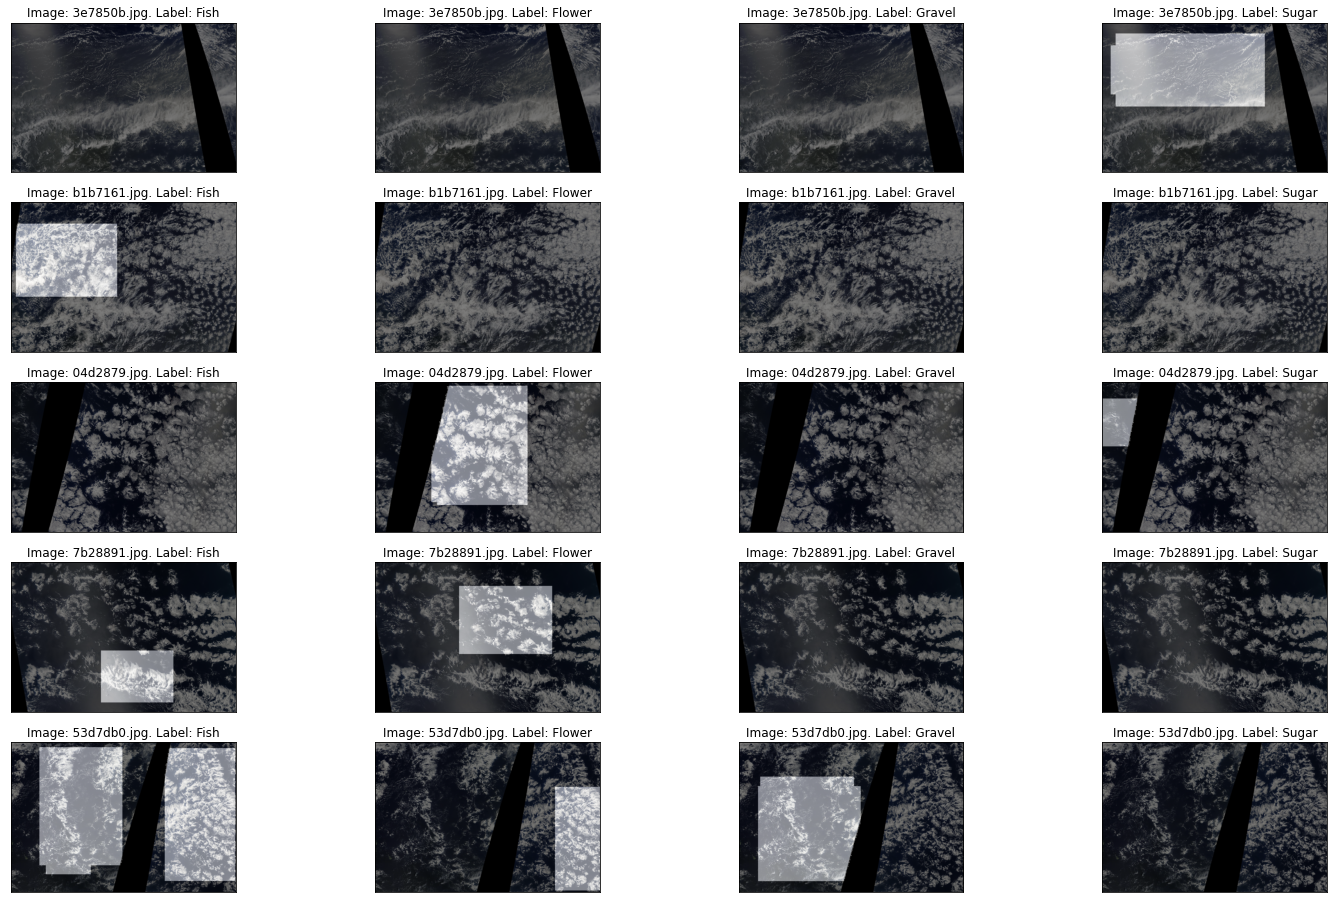

In [101]:
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train_data['im_id'].unique(), 5)):
    for i, (idx, row) in enumerate(train_data.loc[train_data['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{path}/train_images/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        try: # label might not be there!
            mask = rle_decode(mask_rle)
        except:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

### Visualising one image from each class

<ipython-input-174-62b306f8156e>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2, 2, 1+i , xticks=[], yticks=[])


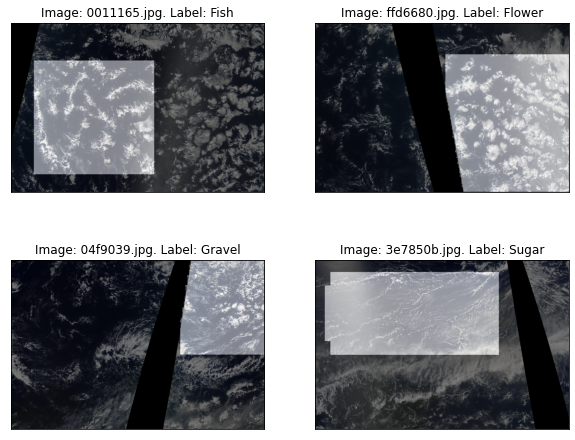

In [174]:
def get_4_ing(img1, img2, img3, img4):
    fig = plt.figure(figsize=(10, 8))
    #for j, im_id in enumerate(np.random.choice(train_data['im_id'].unique(), 1)):
    selected_results = [img1, img2, img3, img4]
    masks = ["Fish", "Flower", "Gravel", "Sugar"]
    for j, im_id in enumerate(selected_results):
        for i, (idx, row) in enumerate(train_data.loc[train_data['im_id'] == im_id].iterrows()):
            ax = fig.add_subplot(2, 2, 1+i , xticks=[], yticks=[])
            if row[2] == masks[j]:
                im = Image.open(f"{path}/train_images/{row['Image_Label'].split('_')[0]}")
                plt.imshow(im)
                mask_rle = row['EncodedPixels']
                try: # label might not be there!
                    mask = rle_decode(mask_rle)
                except:
                    mask = np.zeros((1400, 2100))
                plt.imshow(mask, alpha=0.5, cmap='gray')
                ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")
                
                
get_4_ing("0011165.jpg", "ffd6680.jpg", "04f9039.jpg", "3e7850b.jpg")

**Creating a unique for each image** 

In [78]:
id_mask_count = train_data.loc[train_data['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [58]:
print('training set =',train_ids.shape)
print('validation set =',valid_ids.shape)
print('testing set =',test_ids.shape)

training set = (4991,)
validation set = (555,)
testing set = (3698,)


**The function below is to get the images from folders and preparing it for dislpay**

In [59]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

**The function below is to create mask based on dataframe , image name and shape**

In [60]:
def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks

**The function below if for visualisation**

In [61]:
def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)

In [62]:
image_name = '8242ba0.jpg'
image = get_img(image_name)
mask = make_mask(train_data, image_name)

**The function below is for checking image shape**

In [63]:
def get_img_shape(image):
    height, width, channels = image.shape
    print( height, width, channels)
get_img_shape(image)

1400 2100 3


In [64]:
get_img_shape(image)

1400 2100 3


In [65]:
dsize =(260,260)
image2 = cv2.resize(image,dsize)

In [66]:
get_img_shape(image2)

260 260 3


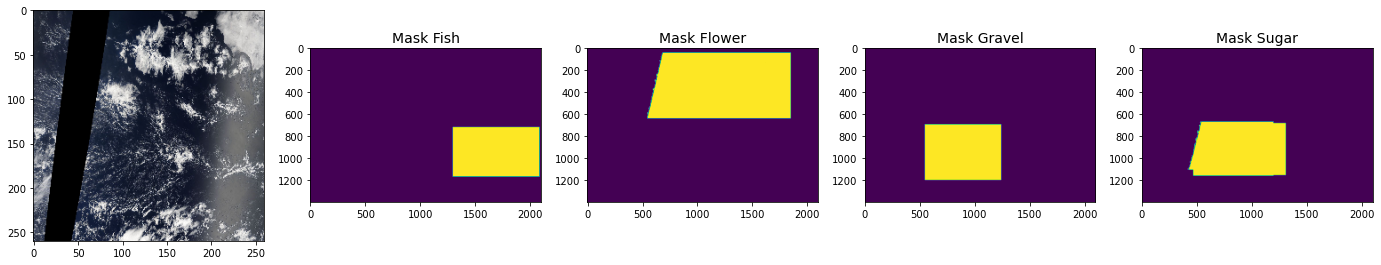

In [67]:
plot1 =visualize(image2, mask)

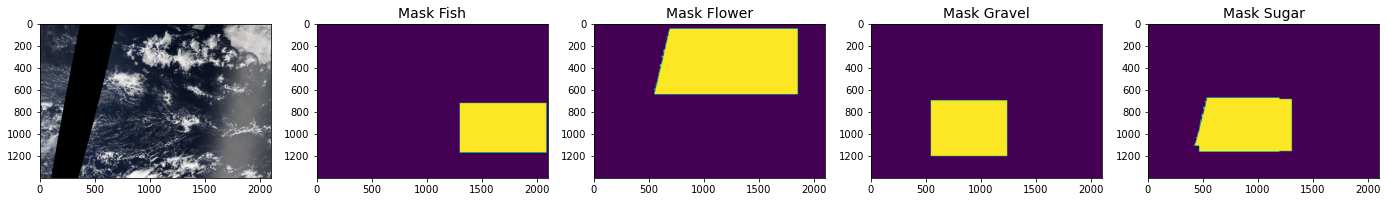

In [68]:
visualize(image, mask)


**The function below is to plot with augmentation**

In [69]:
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))

### plots with differnet augmenatation techniques

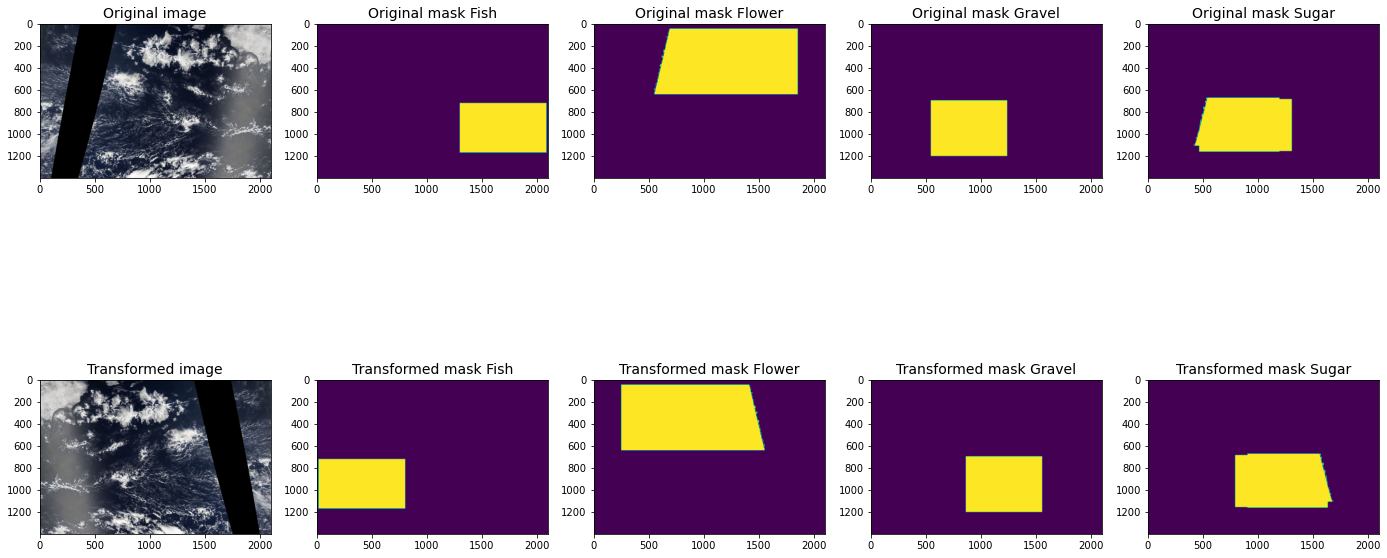

In [70]:
plot_with_augmentation(image, mask, albu.HorizontalFlip(p=1))

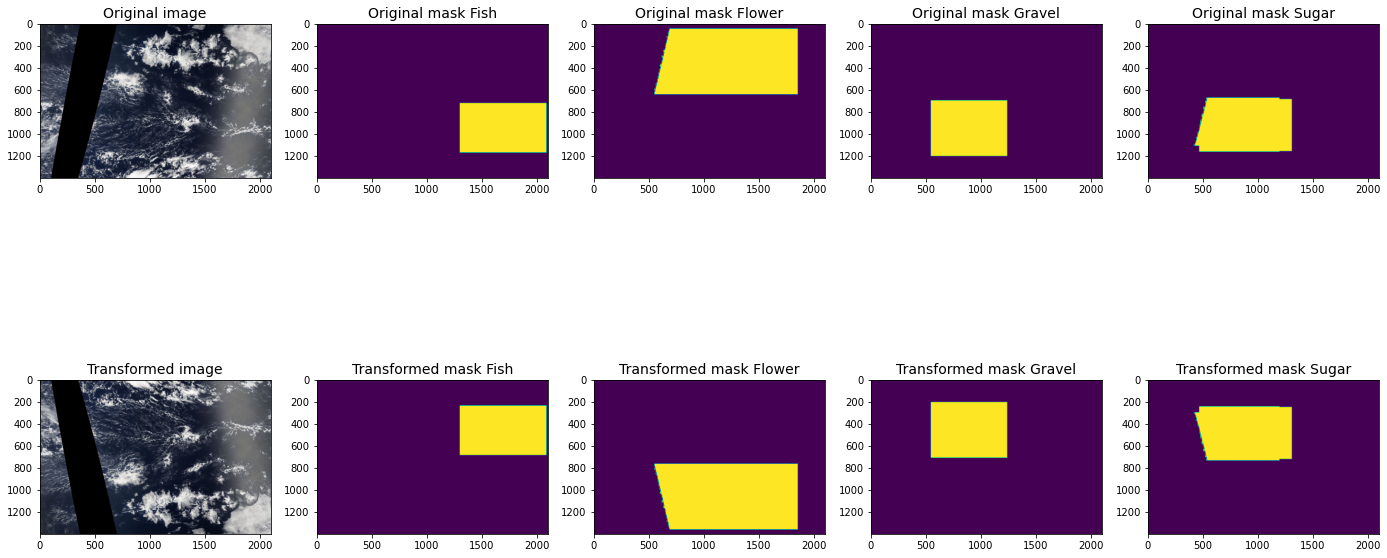

In [71]:
plot_with_augmentation(image, mask, albu.VerticalFlip(p=1))

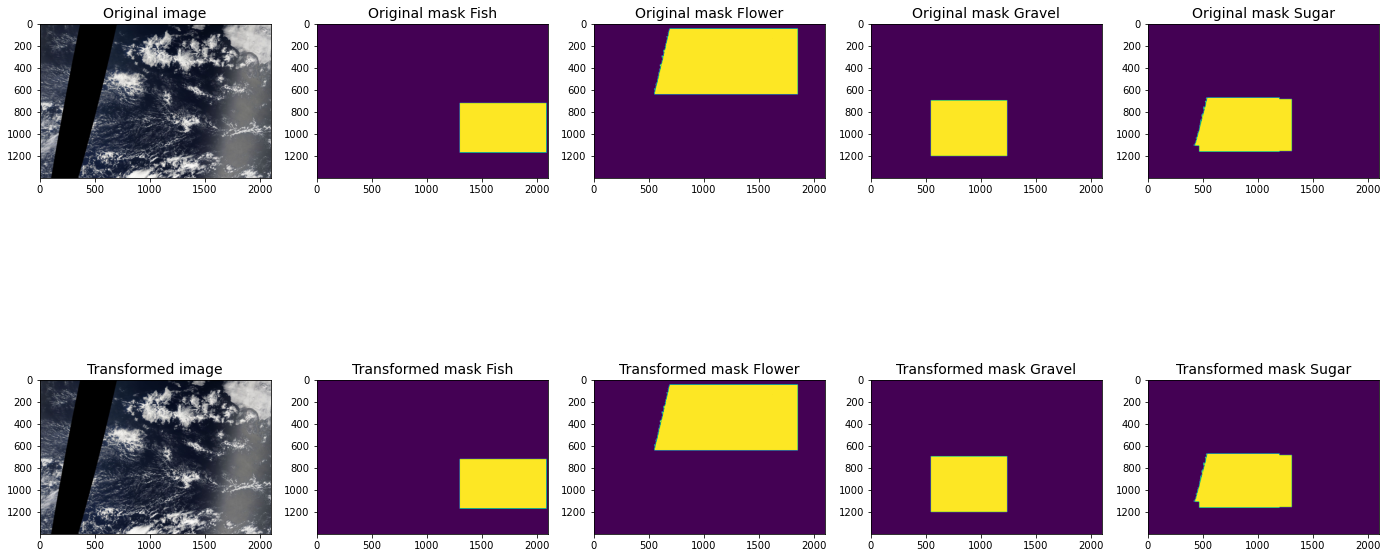

In [72]:
plot_with_augmentation(image, mask, albu.RandomRotate90(p=1))

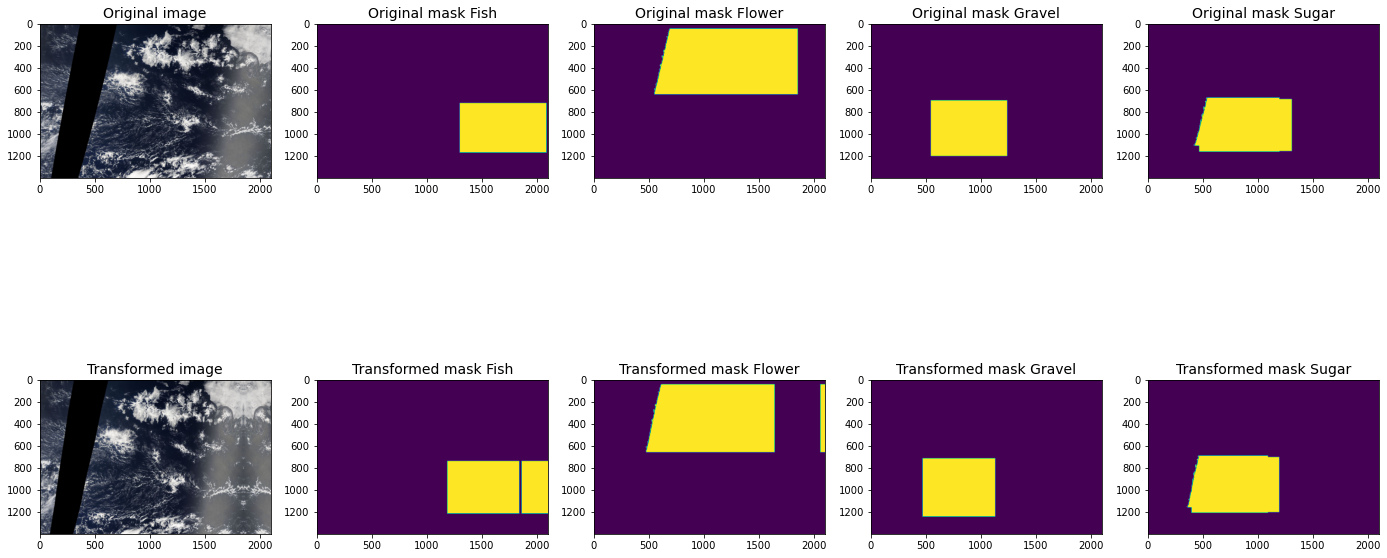

In [73]:
plot_with_augmentation(image, mask, albu.GridDistortion(p=1))

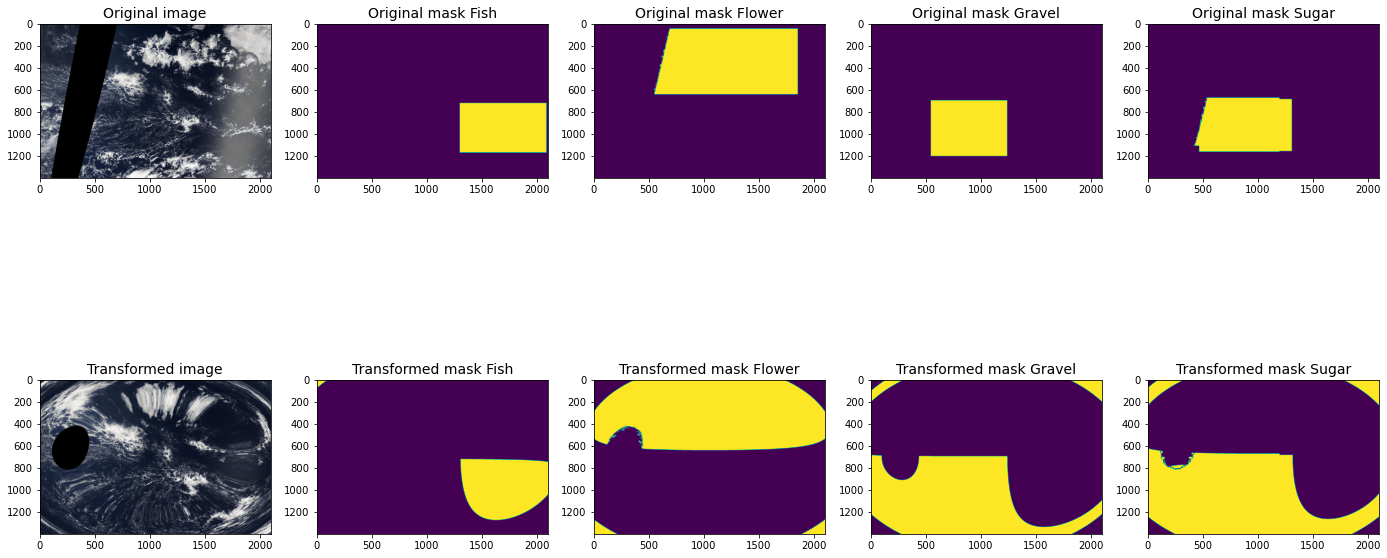

In [33]:
plot_with_augmentation(image, mask, albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5))